**Problem 0**

Run the cell below to make sure you are in the data1030 coding environment. 

We will deduct 2 points for every missing OK sign. (If you don't run the cell, that's -14 points.)


In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.


/Users/henryjiang/opt/anaconda3/envs/data1030/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[ OK ] shap version 0.40.0 is installed.


In [2]:
#conda install seaborn

## Introduction

We are going to explore algorithmic bias using a dataset which contains missing values in this problem set. 

The dataset contains info on criminal offenders screened in Florida during 2013-2014. The csv file and a description are available in the `data` folder. The criminals were reassessed two years after they were released from jail to check whether they commited crime again. This is called recidivism and it is the target variable in the dataset (`two_year_recid`). 

Machine learning models were developed based on this and other similar datasets which are called Risk Assesment Tools (RATs). The goal of the tools is to predict the likelihood of future crime and they are increasingly being used to assess a criminal defendant’s probability of re-offending. The scores calculated by the models inform decisions in all stages of the criminal justice system about assigning bond amounts, criminal sentencing, and who can be set free. As you can imagine, false positives and false negatives have severe consequences for the defendant and society in general.

You will read in and perform EDA on the dataset in problem 1, you'll develop a machine learning model using XGBoost in problem 2, and you'll study algorithmic bias in problem 3. 

You can read more about the topic [here](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) and [here](https://arxiv.org/pdf/2106.05498.pdf).

**Problem 1a (5 points)**

Read in the dataset, separate out the feature matrix and the target variable. 

Print out the datatype of each feature.

Check which features contain missing values, what fraction of values are missing in feature, and whether the features are continuous, ordinal, or categorical. 

Is the target variable continuous or categorical? Please use .describe or .value_counts to take a quick look at it.

Study the gender and race features. Print out the unique races and genders in the dataset. How many people belong to each group?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost

from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import statistics
from statistics import mean

import warnings
warnings.filterwarnings("ignore")


df_crime=pd.read_csv("data/recidivism_data.csv")
df_crime.drop(columns=['id', 'name'],inplace=True)
X=df_crime.loc[:, df_crime.columns != 'two_year_recid']
y=df_crime['two_year_recid']
X_type=X.dtypes
y_type=y.dtypes
print("for the features:",X_type, "for the target variable two_year_recid:", y_type)


for the features: sex                    object
age                     int64
age_cat                object
race                   object
juv_fel_count           int64
juv_misd_count          int64
juv_other_count         int64
priors_count            int64
c_charge_degree        object
r_days_from_arrest    float64
c_jail_days           float64
custody_days          float64
dtype: object for the target variable two_year_recid: int64


In [4]:
df_crime.shape
#shape is (7214, 15)
missing=df_crime.isnull().sum()
#print percentage missing
print(missing/7214)

sex                   0.000000
age                   0.000000
age_cat               0.000000
race                  0.000000
juv_fel_count         0.000000
juv_misd_count        0.000000
juv_other_count       0.000000
priors_count          0.000000
c_charge_degree       0.000000
r_days_from_arrest    0.678958
two_year_recid        0.000000
c_jail_days           0.042556
custody_days          0.032714
dtype: float64


In [5]:
X.head()


,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,r_days_from_arrest,c_jail_days,custody_days
0,Male,69,Greater than 45,Other,0,0,0,0,F,NaN,0.984468,7.0
1,Male,34,25 - 45,African-American,0,0,0,0,F,NaN,10.077384,10.0
2,Male,24,Less than 25,African-American,0,0,1,4,F,0.0,1.085764,0.0
3,Male,23,Less than 25,African-American,0,1,0,1,F,NaN,NaN,NaN
4,Male,43,25 - 45,Other,0,0,0,2,F,NaN,NaN,NaN


In [6]:
y.head()
#target variable is categorical representing whether or not the criminal went back to jail within 2 years.

0    0
1    1
2    1
3    0
4    0
Name: two_year_recid, dtype: int64

In [7]:
X.describe()
X.value_counts()


sex     age  age_cat          race              juv_fel_count  juv_misd_count  juv_other_count  priors_count  c_charge_degree  r_days_from_arrest  c_jail_days  custody_days
Female  19   Less than 25     African-American  0              0               0                0             M                0.0                 1.192257     2.0             1
                              Caucasian         0              0               0                2             F                0.0                 22.274954    48.0            1
Male    32   25 - 45          African-American  0              0               0                3             F                22.0                37.288970    37.0            1
                                                                                                4             F                0.0                 1.050370     0.0             1
                                                                                                                   

In [8]:
print(X['race'].unique())
print(X['race'].value_counts())
print(X['race'].nunique())

print(X['sex'].unique())
print(X['sex'].value_counts())
print(X['sex'].nunique())



['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64
6
['Male' 'Female']
Male      5819
Female    1395
Name: sex, dtype: int64
2


**Problem 1b (10 points)**

Visualize the target variable. We will use accuracy as the evaluation metric. Is the dataset balanced? What's the baseline accuracy? Write a paragraph to explain.

Visualize correlations between the features and the target variable. Prepare at least three figures. As usual, choose an appropriate visualization type, label the axes, use log axes if necessary, and write a caption explaining what the figures show. One figure should show the target variable vs. gender and race.

0    3963
1    3251
Name: two_year_recid, dtype: int64

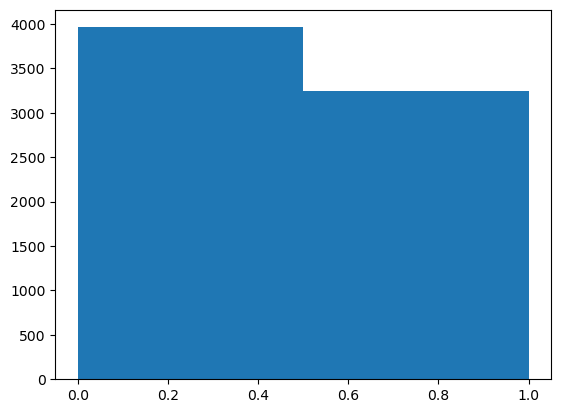

In [9]:

plt.hist(y, bins=2)

y.value_counts()
# base_acc=3963/(3963+3251)

#the data is balanced. The base accuracy would be 55%. This would be the model accuracy if it always predicted 0.

<AxesSubplot:>

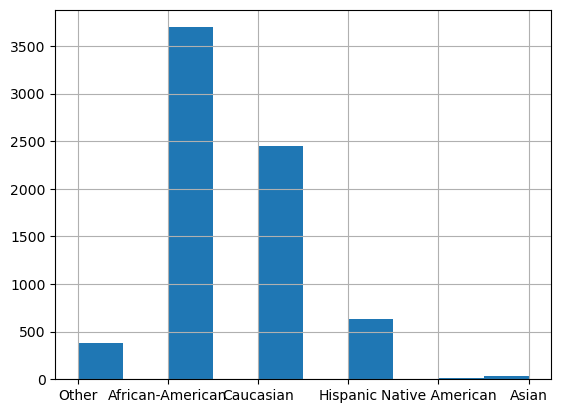

In [10]:

df_crime.corr()

df_crime['race'].hist()

<AxesSubplot:>

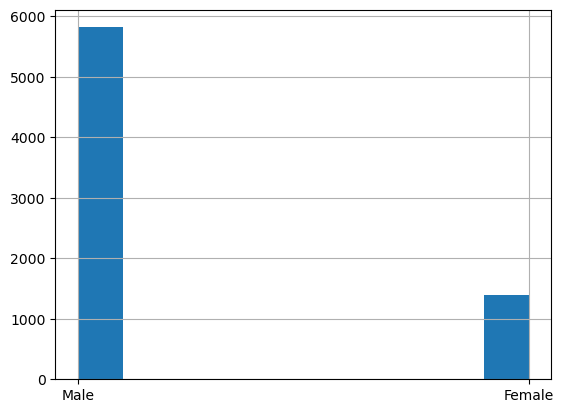

In [11]:
df_crime['sex'].hist()

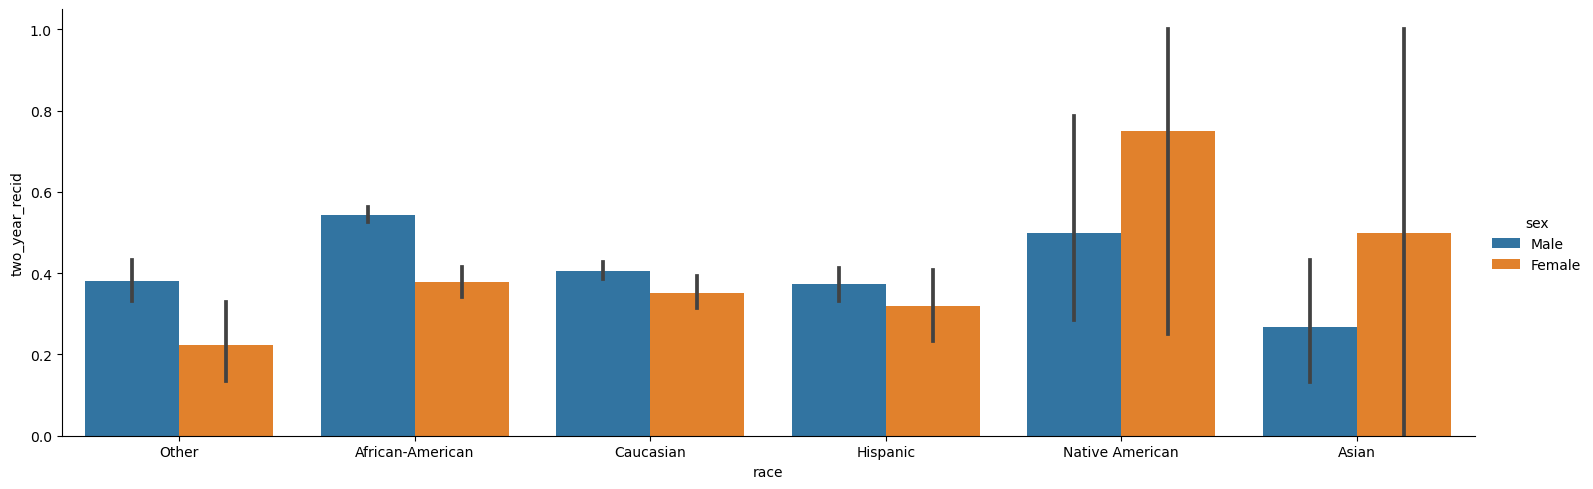

In [12]:

sns.catplot(data=df_crime, x="race", y="two_year_recid", hue="sex", kind='bar', aspect=3)

#Histogram of recidivism amoung races and sexes

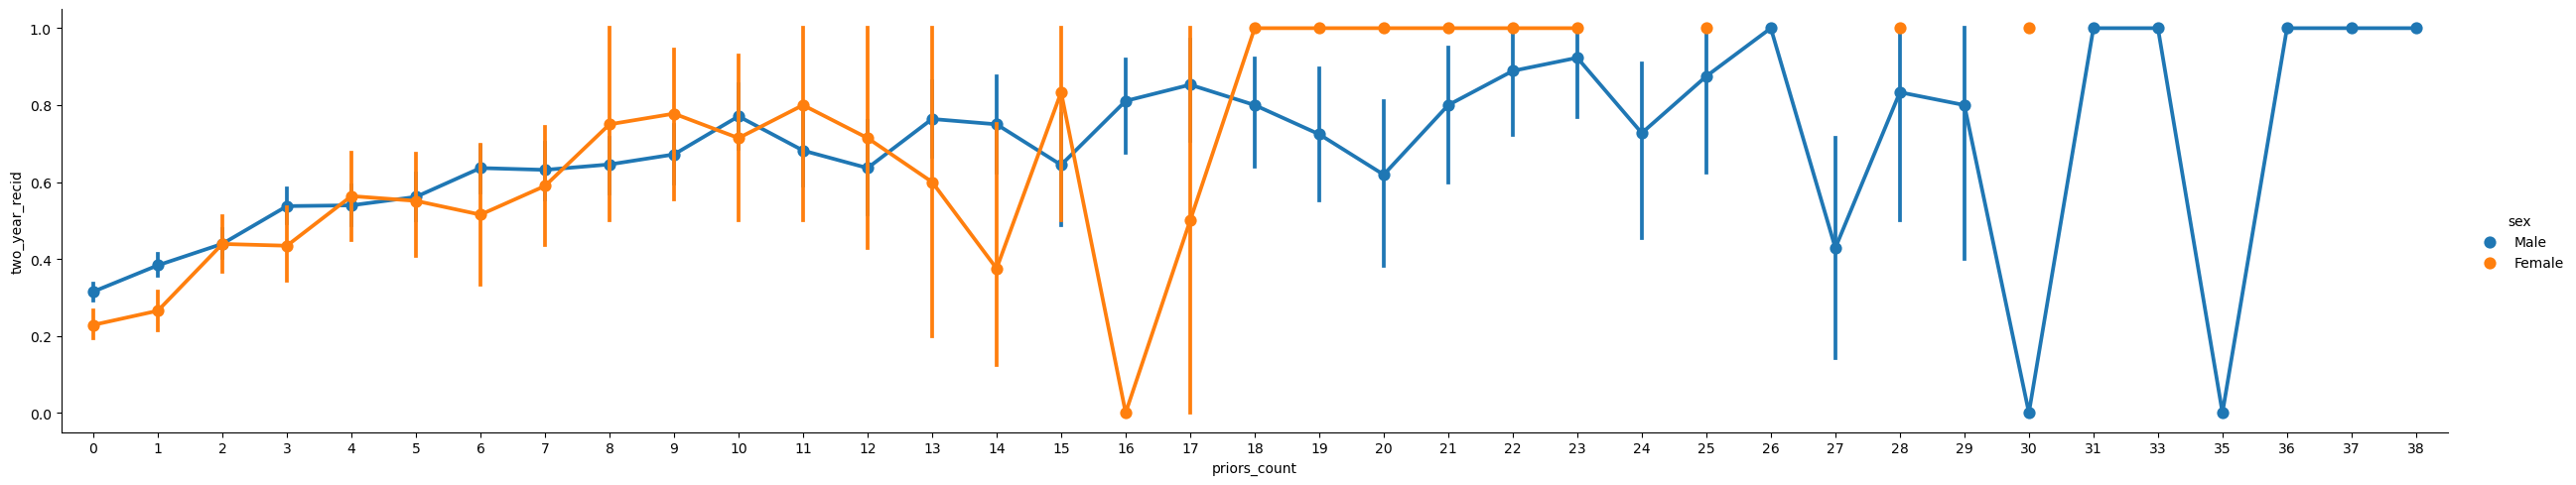

In [13]:
sns.catplot(data=df_crime, x="priors_count", y="two_year_recid", hue='sex', kind="point", aspect=5)

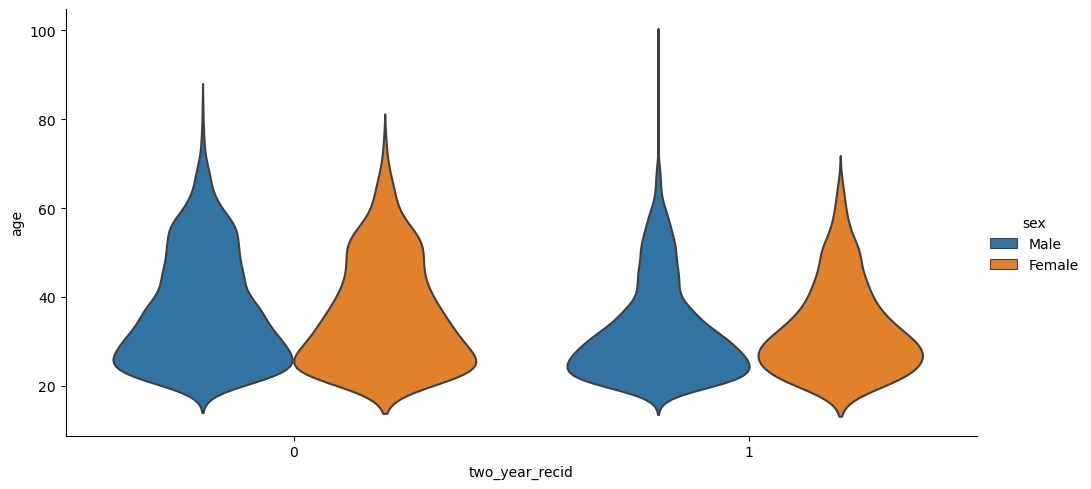

In [14]:
sns.catplot(data=df_crime, x="two_year_recid", y='age', hue='sex', kind="violin", aspect=2, inner=None)

0.5493484890490713


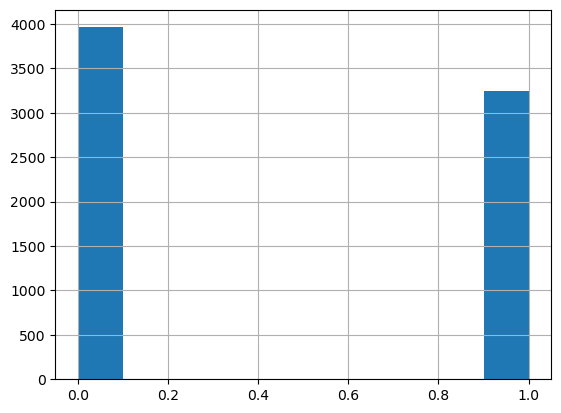

In [15]:
df_crime['two_year_recid'].hist()

df_crime['two_year_recid'].value_counts()

print(3963/(3963+3251))


**Problem 2 (15 points)**

Split, preprocess the dataset, and train XGBoost models.

It is an iid dataset so use the basic train/val/test split.

Preprocess the dataset using a ColumnTransformer.

After you preprocessed the data, calculate and plot the correlation coefficient matrix using the training set. Do we need to drop any features?

Train 5 XGBoost models using 5 different random states. Tune at least one XGBoost hyperparameter and use early stopping.

Collect the test scores, test sets, and the best models in lists. What's the mean and standard deviation of the test accuracy?

<AxesSubplot:>

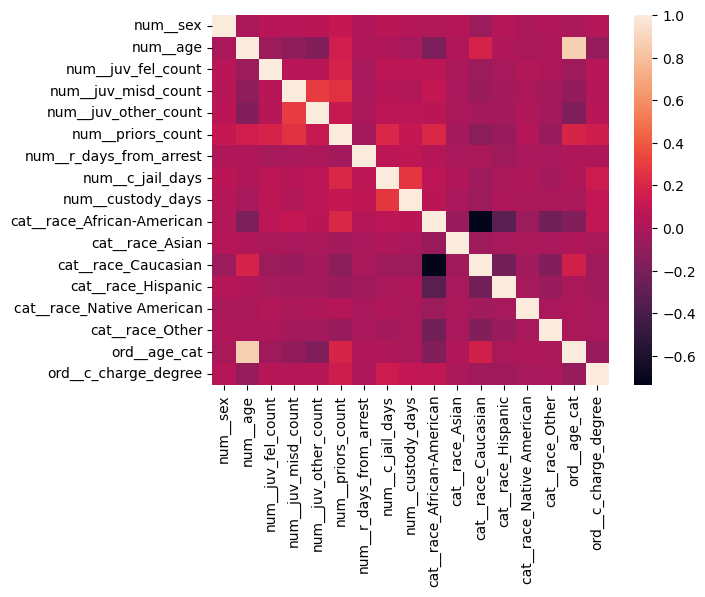

In [16]:

df_crime['sex'] = np.where(df_crime['sex'] == 'Male', 1, 0)
# split data
# Less than 10k points, so using 60-20-20 split

# Collect features/ordinal sequences
cat_ftrs = ['race']
ordinal_ftrs = ['age_cat', 'c_charge_degree']
ordinal_cats = [['NA', 'Less than 25', '25 - 45', 'Greater than 45'], ['NA', 'M', 'F']]
std_scl_ftrs = ['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 
                'r_days_from_arrest', 'c_jail_days', 'custody_days']

# Set up encoders
cat_trsfm = Pipeline(steps=[
    ('imputer_oh', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

ord_trsfm = Pipeline(steps=[
    ('imputer_ord', SimpleImputer(strategy='constant', fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

num_trsfm = Pipeline(steps=[
    ('std_scaler', StandardScaler())])

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trsfm, std_scl_ftrs),
        ('cat', cat_trsfm, cat_ftrs),
        ('ord', ord_trsfm, ordinal_ftrs)])
df_crime.head()

#split the data
X=df_crime.loc[:,df_crime.columns !='two_year_recid']
y=df_crime['two_year_recid']

X_train, X_other, y_train, y_other = train_test_split(X,y, train_size=0.6, random_state=42)
## Preprocess/Transform Data
X_train=preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
train_df = pd.DataFrame(data=X_train, columns=feature_names)


corr_mat=train_df.corr()
sns.heatmap(corr_mat)


In [17]:
best_mod_ls=[]
test_sets_ls=[]
test_scores_ls=[]
#drop age category because it is very correlated with age numerical.
df_crime.drop(columns=["age_cat"])

for rand_state in range(5):
   # print (rand_state)
    X_train,X_other, y_test, y_other=train_test_split(X,y,train_size=0.6,random_state=rand_state)
    X_val,X_test,y_val,y_test=train_test_split(X_other,y_other, train_size=0.5, random_state=rand_state)
    y_train.reset_index(drop=True, inplace=True)
    #print(df_train.shape,y_train.shape)
    
    #build x training data frame
    X_train_tran=preprocessor.fit_transform(X_train)
    feature_names=preprocessor.get_feature_names_out()
    df_train=pd.DataFrame(data=X_train_tran,columns=feature_names)
    y_val.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True) #changes series to a df
   # print(df_val.shape,y_val.shape)
    
    
    #build x val dataframe
    X_val_tran=preprocessor.fit_transform(X_val)
    feature_names=preprocessor.get_feature_names_out()
    df_val=pd.DataFrame(data=X_val_tran,columns=feature_names)
    y_val.reset_index(drop=True, inplace=True) #changes series to a df
    #print(df_test.shape,y_test.shape)
    
    
    #build x test dataframe
    X_test_tran=preprocessor.fit_transform(X_test)
    feature_names=preprocessor.get_feature_names_out()
    df_test=pd.DataFrame(data=X_test_tran, columns=feature_names)
    y_test.reset_index(drop=True, inplace=True) #changes series to a df 
    
    models_ls=[]
    val_scores_ls=[]
    
    for l in np.logspace(-3,3,5):
        for alpha in np.logspace(-3,3,5):
            for g in np.linspace(0.1,0.4,5):
                param_grid = {"learning_rate": [0.03],
                          "n_estimators": [10000],
                          "random_state": [rand_state],
                          "missing": [np.nan], 
                          "colsample_bytree": [0.9],              
                          "subsample": [0.75], 
                          "use_label_encoder": [False]}
                XGB_clf = xgboost.XGBClassifier(reg_alpha=alpha, reg_lambda=l, gamma=g)
                XGB_clf.set_params(**ParameterGrid(param_grid)[0]) 
                XGB_clf.fit(train_df, y_train, 
                        early_stopping_rounds=50, 
                        eval_set=[(df_val, y_val)], 
                        eval_metric='logloss',
                        verbose=False)
                y_val_pred = XGB_clf.predict(df_val, ntree_limit=XGB_clf.best_ntree_limit)
                acc_score = accuracy_score(y_val, y_val_pred)
                val_scores_ls.append(acc_score)
                models_ls.append(XGB_clf)
    #time to find the best model with the best val score
    best_val_score=np.argmax(val_scores_ls)
    best_model=models_ls[best_val_score]
    best_mod_ls.append(best_model)
    
    ## Calculate test score
    y_test_pred = best_model.predict(df_test, ntree_limit=XGB_clf.best_ntree_limit)
    test_acc_score = accuracy_score(y_test, y_test_pred)
    test_scores_ls.append(test_acc_score)  # Save test score
    
    test_set = X_test.reset_index(drop=True).copy()
    test_set['two_year_recid'] = y_test
    test_set['predicted_recid'] = y_test_pred
    test_sets_ls.append(test_set)  # Save test set WITH predictions from best model of random state
    
    
                
            
    


In [18]:
mean_score=mean(test_scores_ls)
std_score=statistics.pstdev(test_scores_ls)

print(mean_score, std_score)

0.8417186417186417 0.005306774696902762


In [19]:
print(test_sets_ls[0].columns)

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree',
       'r_days_from_arrest', 'c_jail_days', 'custody_days', 'two_year_recid',
       'predicted_recid'],
      dtype='object')


**Problem 3 (15 points)**

You will work with the 5 best models and test sets created in Problem 2. 

Use the best models to calculate the predictions of the corresponding test sets. Concatenate the results, drop columns we don't need for the ML bias analysis. You should have one dataframe that contains the racial and gender features, the true and predicted target variables. Print out the column names and the shape of the dataframe.

What's the overall accuracy of the model? Create a confusion matrix to visualize the results.

We will now disaggregate the results and study the model's performance on various racial and gender groups. Let's focus on Caucasians and African-Americans because not many people belong to the other racial groups. Calculate the following:
- accuracy and confusion matrix for males
- accuracy and confusion matrix for females
- accuracy and confusion matrix for Caucasians
- accuracy and confusion matrix for African-Americans

Normalize the confusion matrices with respect to the true conditions. Study the accuracies and the normalized false positives in the confusion matrices!

Write a couple of paragraphs and discuss your findings. How do you feel about the overall accuracy of the model? Are there racial and gender groups for which the model performs better/worse? What do the false positives in the confusion matrix show? 

In [21]:

all_test_scores_df = pd.concat(test_sets_ls).reset_index()  
# Drop unneeded columns
all_test_scores_df.drop([col for col in all_test_scores_df.columns if col not in 
                         ['sex', 'race', 'two_year_recid', 'predicted_recid']], axis=1, inplace=True)

In [22]:
all_test_scores_df.head()

,sex,race,two_year_recid,predicted_recid
0,1,African-American,0,0
1,1,African-American,0,0
2,1,African-American,1,1
3,1,African-American,1,0
4,1,African-American,0,0


In [23]:
# Print column names and DF shape
print(f'Column Names: {[col for col in all_test_scores_df.columns]}')
print(f'DataFrame Shape: {all_test_scores_df.shape}')

Column Names: ['sex', 'race', 'two_year_recid', 'predicted_recid']
DataFrame Shape: (7215, 4)


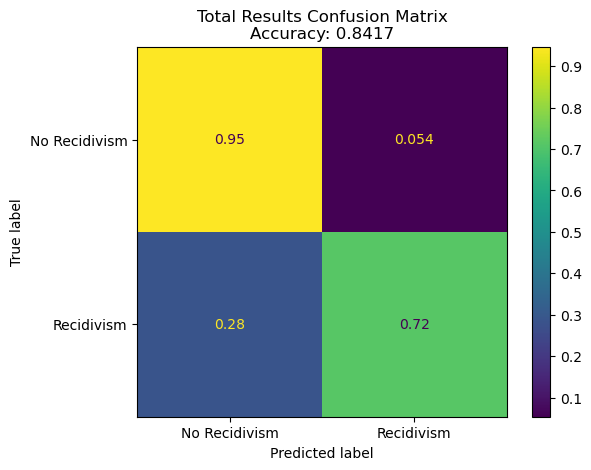

In [24]:
# Total Results
cmd = ConfusionMatrixDisplay(confusion_matrix).from_predictions(
    all_test_scores_df['two_year_recid'], all_test_scores_df['predicted_recid'], normalize='true',
    display_labels=['No Recidivism', 'Recidivism'])
plt.title(f'Total Results Confusion Matrix\n\
Accuracy: {np.round(accuracy_score(all_test_scores_df["two_year_recid"], all_test_scores_df["predicted_recid"]), 4)}')
plt.show()

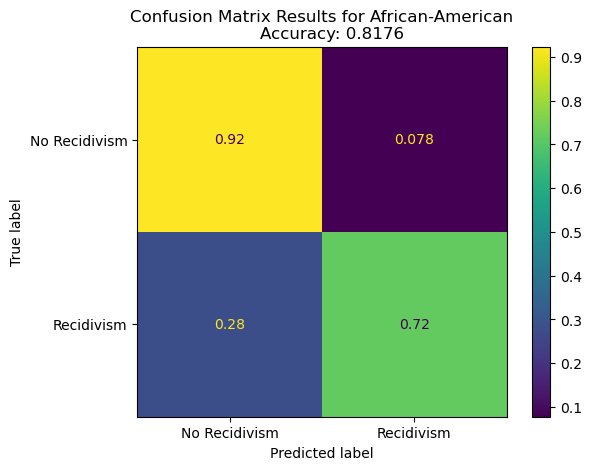

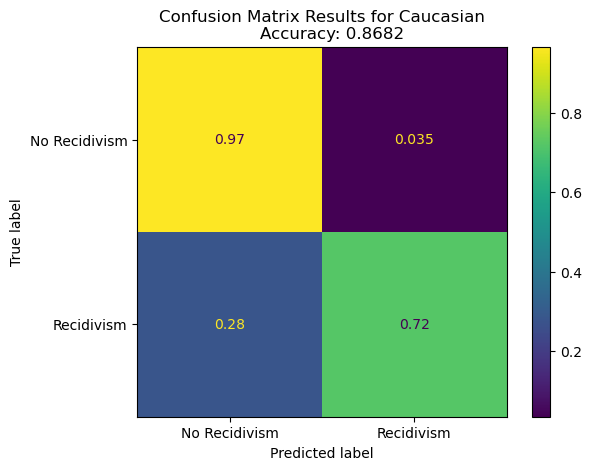

In [25]:
cauc_afro_df = all_test_scores_df[(all_test_scores_df['race'] == 'African-American') | 
                                  (all_test_scores_df['race'] == 'Caucasian')]
# Race
for cats, data in cauc_afro_df.groupby(['race']):
    ConfusionMatrixDisplay(confusion_matrix).from_predictions(
    data['two_year_recid'], data['predicted_recid'], normalize='true', display_labels=['No Recidivism', 'Recidivism'])
    plt.title(f'Confusion Matrix Results for {cats}\n\
    Accuracy: {np.round(accuracy_score(data["two_year_recid"], data["predicted_recid"]), 4)}')

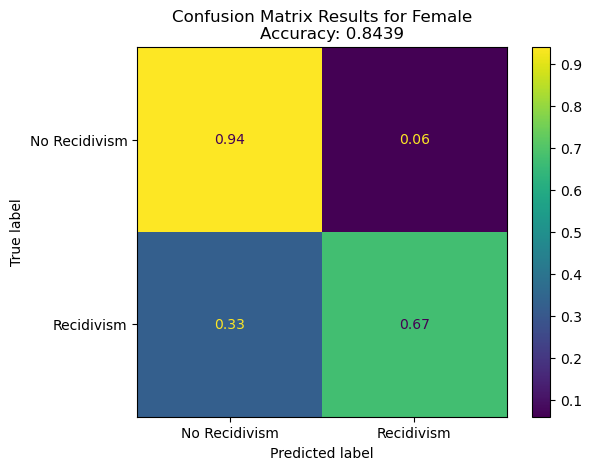

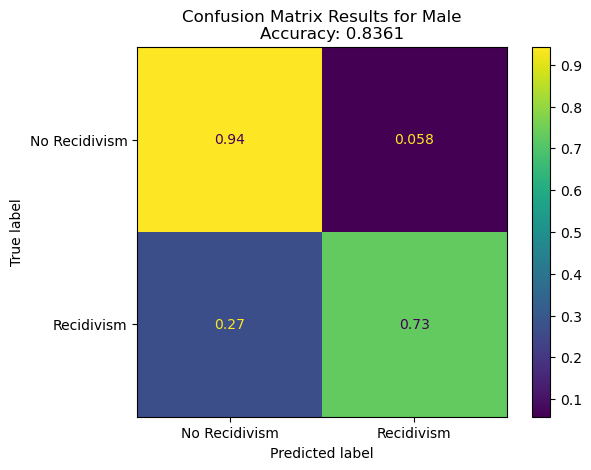

In [26]:
# Sex
cauc_afro_df['sex'] = np.where(cauc_afro_df['sex'] == 1, 'Male', 'Female')
for cats, data in cauc_afro_df.groupby(['sex']):
    ConfusionMatrixDisplay(confusion_matrix).from_predictions(
    data['two_year_recid'], data['predicted_recid'], normalize='true',
    display_labels=['No Recidivism', 'Recidivism'])
    
    plt.title(f'Confusion Matrix Results for {cats}\n\
    Accuracy: {np.round(accuracy_score(data["two_year_recid"], data["predicted_recid"]), 4)}')

There are too many false positives for African Americans. This is due to the fact that they have more positives in the data set. So because they are convicted more in the first place (giving them the benefit of the doubt that they do not indeed commit more crimes in the first place), they are more likely to be convicted in the future given the ML model. In addition, African Americans make up a large proportion of the sample. 